<a href="https://colab.research.google.com/github/Kicory/ML_StockPJ/blob/master/Notebook/Season2/TheGrandPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기초 설정 등

In [1]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# for teaching force
import random

# for CSV
import pandas as pd
import numpy as np

# for visual plot
import matplotlib.pyplot as plt

# for data
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms



In [0]:
torch.manual_seed(470)
torch.cuda.manual_seed(470)

In [0]:
device = 'cuda'

In [0]:
data_dir = os.path.join(gdrive_root, 'Project/Data')

# 시작하기
이 프로젝트에서는 좀 특이한 방식으로 데이터 처리를 해야 합니다. 이유는 다음과 같습니다.

pytorch.nn 의 모듈을 상속받아 만든 클래스로 어떤 모델을 만들었다고 해 봅시다. 해당 모델의 desirable input dimension이 n이라고 합시다.


*   minibatch갯수가 1일 때: n차원의 input을 넣으면 정상 작동(당연)
*   minibatch갯수가 2이상: n + 1차원의 input을 넣음(???)

pytorch가 용하게도 input의 첫 번째 원소를 minibatch의 갯수로 인식하고 input을 minibatch 수만큼 갈라서 병렬 처리를 하는 겁니다. 그러면 input은 n차원의 minibatch개 input으로 나뉘어집니다. 이게 기본 작동 원리입니다.

일반적인 방법으로 데이터를 쪼개면 이런 관례에 따라 minibatch 갯수가 첫 차원의 원소로 들어가게 됩니다. 그런데 지금 우리가 가지고 있는 데이터셋을 일반적인 방법으로 쪼갠다면 다음과 같은 모양을 하게 됩니다.

*   (minibatch 수, 연속된 주식 정보 갯수, 주식 정보(5))

이걸 LSTMCell에 넣으려면 (minibatch, 주식 정보(5))로 가공해서 연속적으로 넣어야 합니다. 그 말인즉슨 0번째 차원과 1번째 원소를 뒤바꿔야 하는데 이거 엄청 비효율입니다.

따라서 데이터셋 가공에 신경을 써서 

*   (연속된 주식 정보 갯수, minibatch 수, 주식 정보(5))

으로 만들어야 합니다.

In [0]:
DATA_PATH = os.path.join(data_dir, 'KOSPI.csv')
CHECKPOINT_PATH = os.path.join(gdrive_root, 'Project/checkpoints/KOSPI_2.pt')

UsingCols = [1, 2, 3, 4, 5, 6, 7, 8]
HiddenSize_1 = 64
DropoutRate = 0.2
HiddenSize_2 = 64

BatchSize = 64

GivenCnt = 8
PredictCnt = 2

#############
UsingColsCnt = len(UsingCols)

# 데이터 준비하기

## 불러오기 및 기본적 가공

In [0]:
DATA = pd.read_csv(DATA_PATH, engine='c', usecols=UsingCols)

In [72]:
TRAIN_DF, TEST_DF = skms.train_test_split(DATA, train_size=0.8, test_size=0.2, shuffle=False)
print('Train :', len(TRAIN_DF), '\nTest :', len(TEST_DF))
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
TRAIN = scaler.fit_transform(TRAIN_DF.to_numpy())
TEST = scaler.transform(TEST_DF.to_numpy())

Train : 5098 
Test : 1275


In [0]:
def unscale(x):
  return scaler.inverse_transform(x)

## 데이터 확인

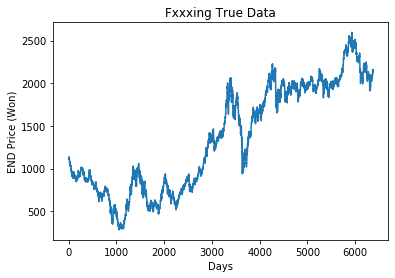

In [47]:
plt.figure()
plt.plot(DATA["END"])
plt.title('Fxxxing True Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

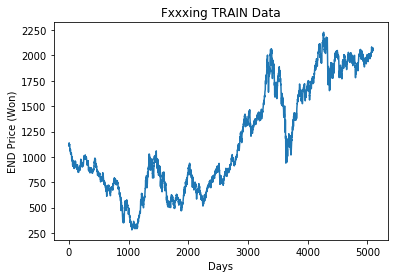

In [33]:
plt.figure()
plt.plot(TRAIN_DF["END"])
plt.title('Fxxxing TRAIN Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

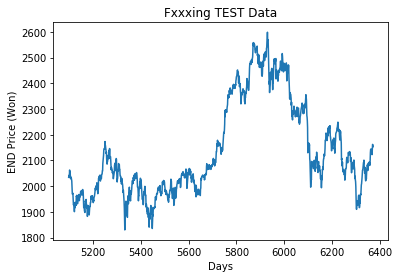

In [34]:
plt.figure()
plt.plot(TEST_DF["END"])
plt.title('Fxxxing TEST Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

## 데이터 가공해서 뿌려주는 함수들

In [0]:
def makeInputUnits(whole, given, predicting):
  entryCnt = whole.shape[0]
  entryDim = whole.shape[1]

  unitLen = given + predicting
  unitCnt = entryCnt - unitLen + 1

  givenEntries = np.zeros((unitCnt, given, entryDim))
  predictEntries = np.zeros((unitCnt, predicting, entryDim))

  for idx in range(unitCnt):
    givenEntries[idx] = whole[idx : idx + given]
    predictEntries[idx] = whole[idx + given : idx + given + predicting]
  
  return givenEntries, predictEntries

In [0]:
def makeBatches(givens, predicts, b_size):
  unitCnt = givens.shape[0]
  unitsLeft = unitCnt

  givenLen = givens.shape[1]
  predictLen = predicts.shape[1]

  entryDim = givens.shape[2]

  unitPointer = 0

  while unitsLeft >= b_size:
    retBatchGivens = givens[unitPointer : unitPointer + b_size]
    retBatchPredicts = predicts[unitPointer : unitPointer + b_size]

    unitsLeft = unitsLeft - b_size
    unitPointer = unitPointer + b_size
    
    yield torch.Tensor(retBatchGivens.swapaxes(0, 1)), torch.Tensor(retBatchPredicts.swapaxes(0, 1))

## 테스트

In [107]:
G, P = makeInputUnits(TRAIN, GivenCnt, PredictCnt)
batIter = makeBatches(G, P, BatchSize)
for bat in batIter:
  GG, PP = bat
  print(GG.shape)
  print(PP.shape)
  break


torch.Size([12, 32, 8])
torch.Size([3, 32, 8])


# 2. 모델 만들기

예를 들어 10일간의 주식 정보를 minibatch 4 개로 해서 train 한다.
hidden size가 32다.
*   x.size() = [10, 4, 5]
*   h0.size(), c0.size() = [4, 32] (근데 이건 어차피 0으로 초기화되니 굳이 설정할 필요는 없..)
*   futureRatio = 얼마만큼을 '예측할' 그래프로 할 것인지
 *   0.5라면 절반 만큼은 teacherForcing 100%, 절반은 teacherForcing 적게.
*   TFRatio = 예측하는 그래프에서 teacherForcing이 일어날 확률.



## 모델 코드

In [0]:
class GrandPredictor(nn.Module):
  def __init__(self, hiddenSize=16, dropoutRate=0.2, FcHiddenSize=16):
    super(GrandPredictor, self).__init__()
    self.lstm = nn.LSTMCell(UsingColsCnt, hiddenSize)
    self.dropout = nn.Dropout(p=dropoutRate)
    self.Fc_mid = nn.Linear(hiddenSize, FcHiddenSize)
    self.relu = nn.ReLU()
    self.Fc_out = nn.Linear(FcHiddenSize, UsingColsCnt)

  def forwardAfterLSTM(self, x):
    x = self.dropout(x)
    x = self.relu(self.Fc_mid(x))
    return self.Fc_out(x)

  def forward(self, givens, predictCnt):
    givens = givens.to(device)
    
    h, c = None, None

    for G in givens:
      if h is None or c is None:
        h, c = self.lstm(G)
      else:
        h, c = self.lstm(G, (h, c))

    predicted = torch.zeros((predictCnt, BatchSize, UsingColsCnt))
    P = self.forwardAfterLSTM(h)
    predicted[0] = P
    for Pday in range(predictCnt - 1):
      h, c = self.lstm(P, (h, c))
      P = self.forwardAfterLSTM(h)
      predicted[Pday + 1] = P
    
    return predicted

## 모델 제작 및 Optimizer 생성

In [77]:
predictor = GrandPredictor(HiddenSize_1, DropoutRate, HiddenSize_2)
predictor = predictor.to(device)
print(predictor)

optimizer = optim.RMSprop(predictor.parameters(), lr=0.01, weight_decay=0.00000001)

GrandPredictor(
  (lstm): LSTMCell(8, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (Fc_mid): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (Fc_out): Linear(in_features=64, out_features=8, bias=True)
)


## 모델 테스트(오류 없이 돌아가는가)

In [86]:
predictor(torch.zeros((GivenCnt, BatchSize, UsingColsCnt)), PredictCnt)

torch.Size([32, 8])


tensor([[[ 0.1534, -0.3066, -0.0707, -0.1122, -0.1593,  0.3284, -0.1162,
           0.1139],
         [ 0.1655, -0.2837, -0.0723, -0.1407, -0.1570,  0.3040, -0.1383,
           0.0954],
         [ 0.1511, -0.2900, -0.0806, -0.1413, -0.1431,  0.3271, -0.1227,
           0.1068],
         [ 0.1097, -0.3028, -0.1587, -0.1429, -0.1605,  0.3225, -0.1445,
           0.1499],
         [ 0.1189, -0.3106, -0.1352, -0.0981, -0.1666,  0.2813, -0.1549,
           0.1307],
         [ 0.1147, -0.3045, -0.1573, -0.1089, -0.1682,  0.2868, -0.1557,
           0.1432],
         [ 0.0916, -0.3057, -0.1144, -0.1423, -0.1873,  0.2793, -0.1554,
           0.1517],
         [ 0.1509, -0.2868, -0.0613, -0.1303, -0.1570,  0.2829, -0.1381,
           0.0942],
         [ 0.1627, -0.3018, -0.0912, -0.1344, -0.1713,  0.3274, -0.1353,
           0.1178],
         [ 0.1582, -0.3030, -0.0929, -0.1009, -0.1543,  0.2971, -0.1374,
           0.1036],
         [ 0.1231, -0.2954, -0.0478, -0.1469, -0.1643,  0.3135, -0.143

# Training

## Checkpoint Load
체크포인트 경로는 파일 최상단 config 부분에서 수정

In [0]:
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

ckpt_path = CHECKPOINT_PATH
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    predictor.load_state_dict(ckpt['predictor'])
    optimizer.load_state_dict(ckpt['optimizer'])
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')

## Training Code

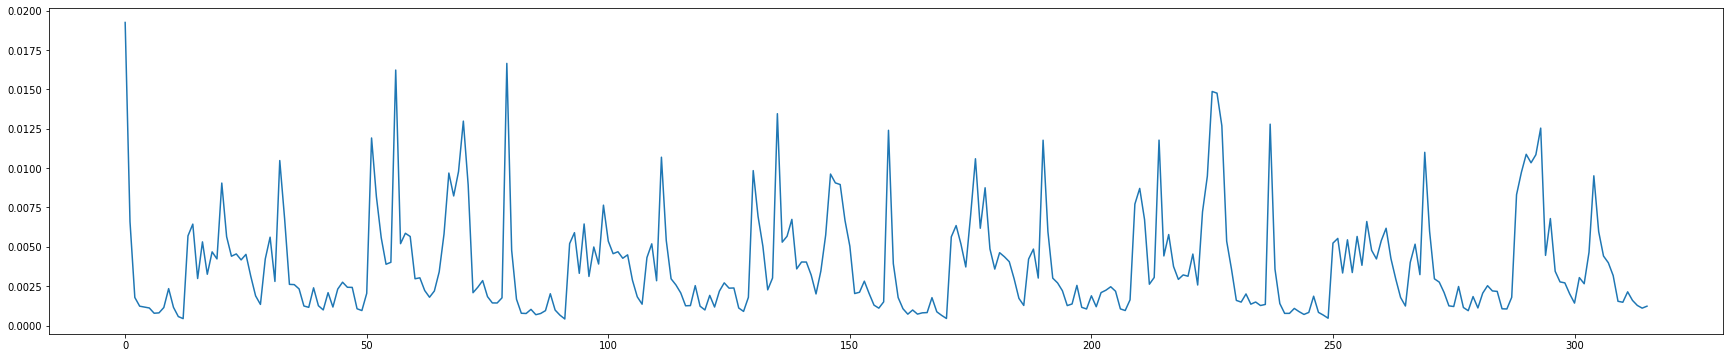

In [83]:
# Training process
maxEpoch = 4

losses = []
prices = []

givenSets, trueSets = makeInputUnits(TRAIN, GivenCnt, PredictCnt)

predictor.train()
it = 0
for epoch in range(maxEpoch):
  batchIter = makeBatches(givenSets, trueSets, BatchSize)

  for bat in batchIter:
    it = it + 1

    givenData, trueData = bat

    predictedData = predictor(givenData, PredictCnt)

    loss = F.mse_loss(predictedData, trueData)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(30, 6))
plt.plot(losses, label='train loss')
plt.show()

## Checkpoint Saver
결과가 좋다면 체크포인트를 저장하자.

In [0]:
ckpt_path = CHECKPOINT_PATH
ckpt = {'predictor':predictor.state_dict(),
        'optimizer':optimizer.state_dict()}
torch.save(ckpt, ckpt_path)

# TEST!!

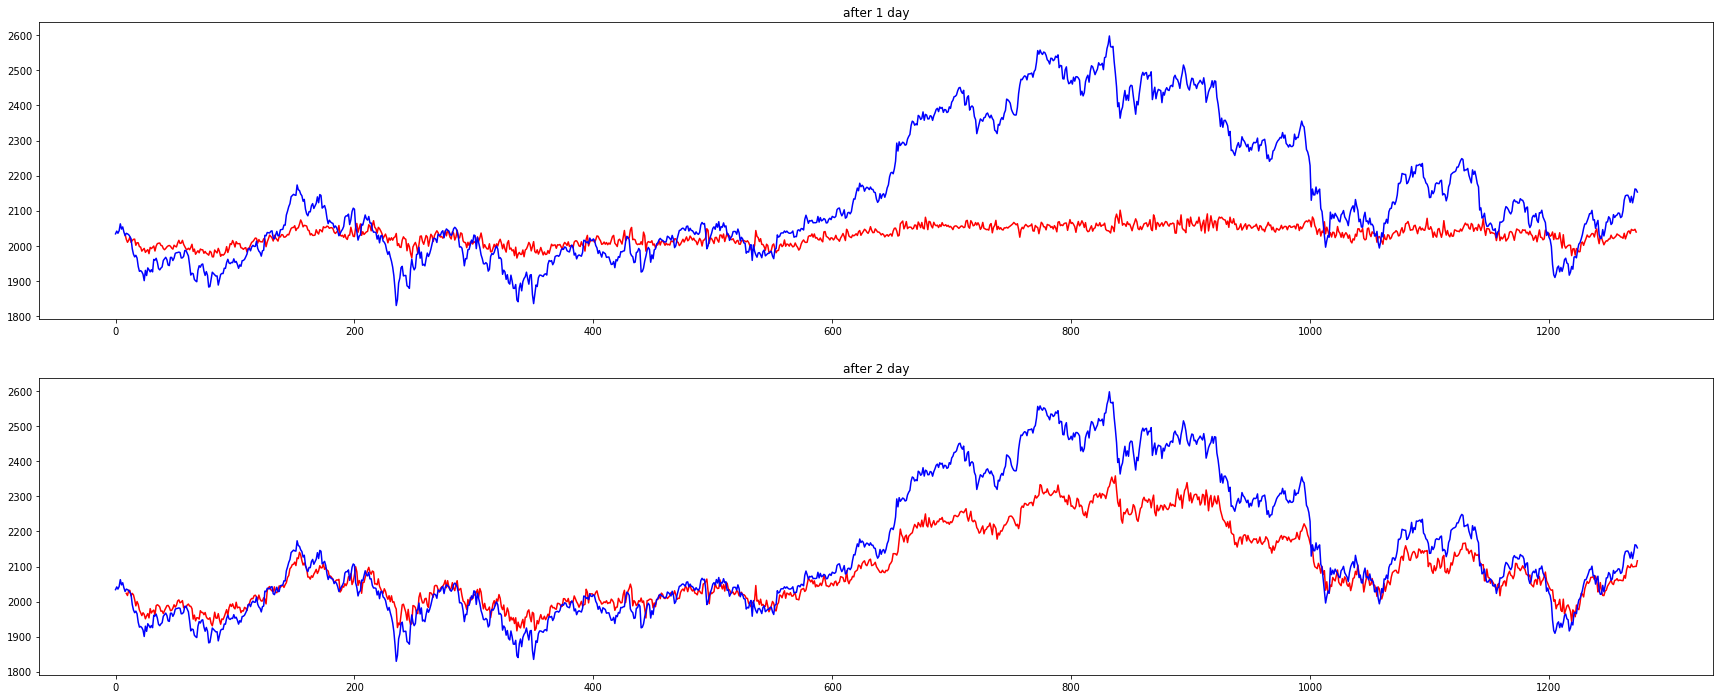

In [84]:
from google.colab import widgets

def drawStepFig():
  predictor.eval()

  testSampleCnt = len(TEST)
  predVals = np.full((PredictCnt, testSampleCnt), None, dtype=np.float64)
  trueVals = TEST_DF.to_numpy()[:, 0]

  givenSets, trueSets = makeInputUnits(TEST, GivenCnt, PredictCnt)
  batIter = makeBatches(givenSets, trueSets, 1)

  day = GivenCnt - 1
  for batch in batIter:
    Gset, Tset = batch
    estis = unscale(predictor(Gset, PredictCnt).detach().numpy()[:, 0, :])[:, 0]
    
    for fore in range(1, PredictCnt + 1):
      if fore + day < testSampleCnt:
        predVals[fore - 1, fore + day] = estis[fore - 1]
    day = day + 1

  plt.figure(figsize=(30, PredictCnt * 6))
  
  for i in range(1, PredictCnt + 1):
    plt.subplot(PredictCnt, 1, i, title='after ' + str(i) + ' day')
    idx = i - 1
    plt.plot(predVals[idx], '-r')
    plt.plot(trueVals, '-b')
  plt.show()

drawStepFig();

In [0]:
import plotly